# Cloud Diffusion Part 2: Overview
In this notebook we give an overview of Cloud Diffusion for image generation. This is the second notebook in a series:
1. [Cloud Diffusion Part 1: Scale Invariance](./CD_Scale_Invariance.ipynb)
2. [Cloud Diffusion Part 2: Overview (this notebook)](./CD_Overview.ipynb)
3. [Cloud Diffusion Part 3: Training](./CD_Training.ipynb)
4. [Cloud Diffusion Part 4: Inference](./CD_Inference.ipynb)

Cloud Diffusion operates on the same principles as ordinary diffusion models to generate images. The primary difference lies in the noise used in the diffusion process. While classic diffusion models use white noise to progressively introduce noise to the images, Cloud Diffusion uses scale invariant noise with parameters that are tuned to the statistical properties of the data set. Both models train a network to separate the signal from the noise. However, the characteristic properties of cloud noise may necessitate a different network architecture.

In [2]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import time
import importlib
import data
import helpers
import RealFFT
from RealFFT import fft
from RealFFT import ifft
from RealFFT import rfft
from RealFFT import irfft
from IPython.display import clear_output

In [29]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(RealFFT)

<module 'RealFFT' from '/Users/ac.randono/Python Projects/AI Experiments/Scale Invariance/RealFFT.py'>

In [3]:
device = helpers.getDevice()
print(device)

mps


## Motivation

In [Cloud Diffusion Part 1: Scale Invariance](./CD_Scale_Invariance.ipynb) have argued that natural image sets can be modelled better by scale invariant noise between pink noise and red (Brownian) noise than by white noise. We now apply these concepts to generative diffusion models. In these models, an image set is progressively corrupted by adding white noise to image set. The model is then trained to identify the noise at each step of the noising schedule, separating out the signal from the noise. The model can then be run in reverse to take an arbitrary white noise image, predict the reverse noising schedule, and remove to the noise to reveal the generated image. There has been much progress in the development of these models, but they still suffer from some defficiencies. Among the problems with traditional diffusion models that we hypothesize can be improved by appropriately employing scale invariant noise fit to the training dataset:

<b>Faster Image Generation:</b> As we have hinted at, Cloud Noise whose parameters are tuned to a natural image dataset is a normal distribution that is closer, in a quantifiable sense, to the probability distribution of the image set than white noise. Thus, if we train a Cloud Noise model and seed it with cloud noise to generate an image, the inference process will have to traverse a shorter distance than if we started with a white noise diffusion model seeded with white noise. Diffusion models typicall generate images through a lengthy iterative process, essentially reversing the forward diffusion process by removing noise at each backward time step. We should expect then that since the cloud noise seed is closer to the image set that the Cloud Noise Diffusion model will not require as many time steps to generate high quality images, potentially increasing the inference speed.

<b>Improved Short Wavelength Fidelity:</b> Images generated from diffusion models are remarkable in their image quality, but to a trained eye they are often easy to identify by paying attention to the details. The images details tend to have an unrealistically smoothed and polished look, leading to what we might anachronistically refer to as an "airbrushed" or "ultra-processed" quality. There are many factors that contribute to this including the compression and decompression phases of latent diffusion models, and heavy use of upscaling from low to high resolution. However, our hypothesis here is that this is not the whole story. The models work by progressively identifying signal from noise and removing the noise over a long sequence of steps. White noise diffusion models obscure fine details early in the forward diffusion process while retaining coarse features until late timesteps. Consequently, the timestep window where the model can distinguish fine details from noise reasonably well only comes late in the time schedule and it is short lived. This is particularly problematic as high frequencies (short wave lengths, or fine details) occupy a larger volume in Fourier space than low frequencies (long wavelengths, or coarse features). Consequently, diffusion models often undertrain the fine details giving rise to a smoothing effect at small scales, yielding the "airbrushed" quality of diffusion generated images. This can be mitigated by modifying the diffusion schedule, and this is often done by introducing a sinusoidal schedule that lengthens the window where fine details can be discriminated from noise. However, at a fundamental level, white noise diffusion still must train and generate images in a sequential order of coarse features to fine details. By contrast, the Cloud Diffusion models use scale invariant noise tailored to the dataset, forcing the model to train all frequencies simultaneously. Consequently the model must allocate comparable compute time to small scale, mid scale, and large scale features. The net effect is that the model trains and generates the images more holistically, addressing all frequencies at the same time, and improving the high frequeny fidelity of generated images.

<b>Improved Conditional Guidance:</b> We expect that for certain scenarios a conditionally guided Cloud Diffusion model may function better than its white noise counterpart. This again comes back to the way that images are generated. In white noise diffusion models, images are generated through an iterative process of removing noise. A conditionally guided model injects guidance prompts throughout the reverse diffusion procedure to steer the generative algorithm. Since fine details only emerge at late times during inference, guidance that conditions the generation of fine details is only effective at late timesteps. This can be problematic if, for example, the composition of an image is built around fine details. By contrast, since the Cloud Diffusion models generates all frequencies simultaneously, it may improve conditional guidance of fine detail prompts.

An example is in order. Suppose we train a model an image set of _Where's Waldo_ type images and generate images through prompts that describe where Waldo is located in the image as well as visual distractions to distract attention away from Waldo. As Waldo's image is typically small and comprised of fine details, in the inference process for a white noise diffusion model, the location of Waldo and all the visual details surrounding him can only by generated at late stages of the inference procedure. This leaves little time for the model to adjust the composition of the image around the prompted details (Waldo in this case). By contrast, the Cloud Noise diffusion model can generate fine details very early in the inference procedure that can be used to guide other details and composition.

## Real Fourier Transforms
In this section we take a diversion to introduce a tool that we will use in analysis and training. We will make extensive use of Fourier analysis in what follows, and it would be nice if we could still work with real tensors that have the same shape shape as the original images, and similar power-law statistics to their complex counterparts in ordinary Fourier Space. This section develops these tools. 

The Fourier transform of a real $N\times N$ tensor is a complex $N\times N$ tensor whose components are not entirely indepedent. In particular given a real image $f(x,y)$, its Fourier transform $F(k_x, k_y)=\mathcal{F}(f)$ satisfies 
$$
F(-k_x, -k_y)=F(k_x, k_y)^*\,.
$$
In tensor form, the Fast Fourier Transform $Z^{ij}=\mathcal{F}(x^ij)$ of a real image $x^{ij}$ satisfies a similar relation. We write this as
$$
Z^{\tilde{i}\tilde{j}} = (Z^{ij})^*
$$
where the indices $\tilde{i}$ and $\tilde{j}$ are related to $i$ and $j$ via an involution. When $N$ is odd this involution is simple: it simply inverts the coordinates about the origin of the image, which is the pixel directly in the center. When $N$ is even, it is slighlty more complicated as the first row and first column must be treated separately. Regardless, if one counts up the total independent degrees of freedom, taking into account the skew-Hermitian relations between pixels, the total real degrees of freedom must equal $N\times N$. 

This suggests that one could find a real representation of the image in Fourier space that contains the same information as the original image. While torch has methods that purport to isolate the true degrees of freedom (e.g. <a href="https://pytorch.org/docs/stable/generated/torch.fft.rfft2.html#torch.fft.rfft2">torch.fft.rfft2</a>), in practice one finds that this method still returns a complex tensor whose components are not all independent.

Our goal here is to find a modified Fast Fourier Transform $X^{ij}=\mathcal{F}_{\mathbb{R}}(x^{ij})$ of a real image that:
1. Is itself real-valued
2. Has the same information content as the ordinary 2D FFT
3. Returns a tensor of the same shape ($N\times N$ for square input)
4. Respects the power-law statistical properties of the image set

Our strategy can be explained qualitatively as follows. Divide up $Z^{ij}=\mathcal{F}(x^{ij})$ into two sectors (roughly the upper and lower half planes) that are images of each other under the involution $(i,j)\rightarrow (\tilde{i},\tilde{j})$. Combine the real part of one sector with the imaginary part of the other to form a real tensor. The result has the same information as the ordinary Fast Fourier Transformed image, and indeed we define an inverse transformation that takes $X^{ij}$ back to $Z^{ij}$. Since we are dealing with image sets where both the real and imaginary parts of $Z^{ij}$ each satisfy the same power-law statistics in aggregate, $X^{ij}$ will also have power-law statistics in aggregate.

Below we show the Real FFT of an image to demonstrate that the modified FFT has the intended properties. The middle image is the real representation $X^{ij}=\mathcal{F}_{\mathbb{R}}(x^{ij})$, and the third image is the inverse $\mathcal{F}_{\mathbb{R}}^{-1}(X^{ij})$. As expected, the inverse returns the original image. 

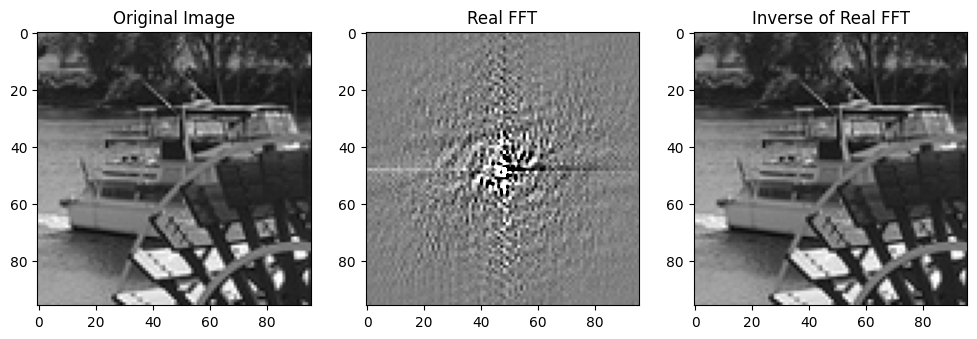

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
for i in range(4):
    randint = np.random.randint(len(clean_dataset))
    
    x = clean_dataset[randint][0].squeeze()
    X = rfft(x)
    x2 = irfft(X)
    
    axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
    axs[1].imshow(X, vmin=-.4, vmax=.4, cmap="gray")
    axs[2].imshow(x2, vmin=0, vmax=1, cmap="gray")
    
    axs[0].set_title("Original Image")
    axs[1].set_title("Real FFT")
    axs[2].set_title("Inverse of Real FFT")

plt.show()

### Power Law Variance in Real Fourier Space
To demonstrate that the variance tensor, call it ${(\Sigma_\mathbb{R})^{ij}}_{kl}$ in Real Fourier Space still is still of power-law form, we first compute the variance tensor:

In [38]:
sigma_real_fft = helpers.get_sigma(dataloader, mu, std, realFFT=True, device=device)

Completed in 24.85021710395813 seconds.


Plotting the variance for various values of $(k,l)$, we see the familiar diagonal form ${(\Sigma_\mathbb{R})^{ij}}_{kl}\approx \Sigma^{ij}_{\mathbb{R},diag} \delta^i_k\delta^j_l$:

tensor(-49.2242, device='mps:0') tensor(1921.9343, device='mps:0')


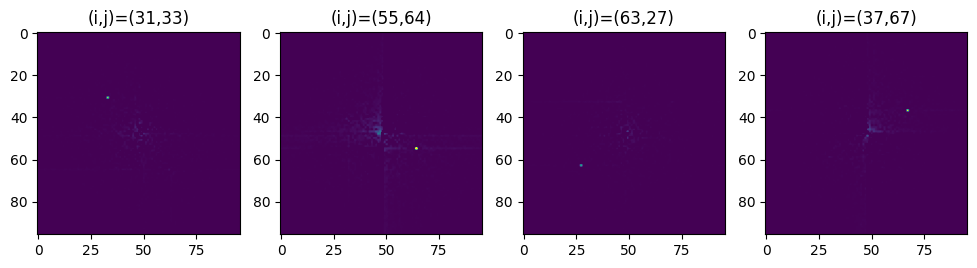

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 13))
points = [[31,33], [55,64], [63,27], [37,67]]
for n in range(4):
    i = points[n][0]
    j = points[n][1]
    axs[n].set_title(f"(i,j)=({i},{j})")
    axs[n].imshow(sigma_real_fft[:,:,i,j].to("cpu"), vmin=0, vmax=.1)

print(sigma_real_fft.min(), sigma_real_fft.max())

As we did with the complex variance tensors in [Cloud Diffusion Part 1: Scale Invariance](./Scale_Invariance.ipynb), after masking out the central cross region, we plot the radial dependence of the diagonal variance in a log-log plot and fit it linearly to get the parameters $A$ and $\Delta$:

From the slope of the log-log plot we determine the factors A and ∆:
A=0.03586860562465345
∆=1.499858054433354


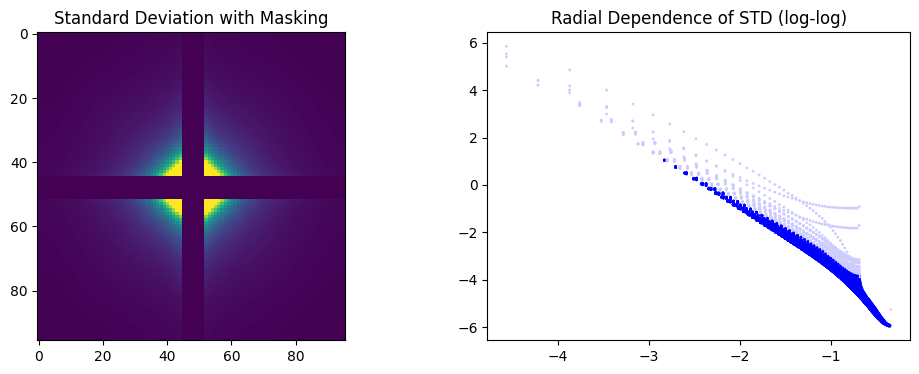

In [40]:
A, Delta = helpers.get_radial_dependence(sigma_real_fft, a=4, R=.7)

As expected, the variance tensor in Real Fourier Space has the diagonal power form:
$$
{(\Sigma_\mathbb{R})^{ij}}_{kl}\approx A^2 \frac{\delta^i_k\delta^j_l}{|k|^{2\Delta}}
$$
with $\Delta \approx 1.5$. 

Moving forward, we will usually use the Real Fast Fourier Transorm in place of the ordinary FFT. This will allow us to work with real numbers in Real Fourier Space with tensors that have the same shape as the images in real space without losing the power-law statistics that are the basis of Cloud Diffusion. 

## Forward Diffusion Process
As shown in [Cloud Diffusion Part 1: Scale Invariance](./CD_Scale_Invariance.ipynb), natural image sets typically exhibit a power law spectrum when analyzed statistically, and the scaling parameter is characteristic of the image set. Thus, to lowest order, natural image sets  are subsets of the scale invariant normal distribution $\mathcal{N}(\mu, \Sigma)$ where in general, $\Sigma$ is not diagonal but has a characteristic fall off with distance. In Fourier space, the complex variance tensors $\Gamma$ and $C$ are approximately diagonal and they satisfy:
$$
{\Sigma^{ij}}_{kl} \approx \frac{A^2}{r^{2\Delta}} \delta^i_k\delta^j_l \quad \quad {C^{ij}}_{kl} \approx {\Gamma^{ij}}_{\tilde{k}\tilde{l}}
$$
where $\tilde{k}$ and $\tilde{l}$ represent the indeces $k$ and $l$ mirrored around the origin, and $r=r(i,j)$ is the radius function normalized so the edges are at $r=0.5$. Thus, to lowest order, the image set in Fourier space is a subset of the complex normal distribution $\mathcal{N}_{\mathbb{C}}(M, \Gamma, C)$ where $M^{ij}=\mathcal{F}(\mu^{ij})$ is the pointwise norm in Fourier space. We typically normalize the image set by subtracting out the mean so that $M^{ij}=0$. Natural image sets also exhibit kurtosis (deviation from Gaussianity), which distinguishes them at the statistical level from normal distributions. However, these are typically higher order effects (usually fourth-order as opposed to the second-order variance tensors). Thus, we can still safely say that to lowest order natural image sets are an approximate subset of scale invariant normal distributions.

As we have shown in [Cloud Diffusion Part 1: Scale Invariance](./CD_Scale_Invariance.ipynb), since we are dealing with real valued images, it is often convenient to work with a real representation of the Fourier Transform that is itself real valued while containing the same information as the ordinary Fourier Transform and retaining the most important statistical properties of the set. The Real FFT is defined in [RealFFT](./RealFFT.py). We will refer to the target space of the real fast Fourier Transform as _Real Fourier Space_. In Real Fourier space, to lowest order natural image sets typically are approximate subsets of $\mathcal{N}(M, \Sigma)$ where $\Sigma$ is the _real_ variance tensor satisfying:
$$
{\Sigma^{ij}}_{kl}\approx \frac{A^2}{r^{2\Delta}}\delta^i_k \delta^j_l
$$
Note that the variance is real and diagonal in Real Fourier Space, and it obeys power law statistics. The diagonal nature means that the noising process for our Cloud Diffusion model works in a very similar way to the standard noising procedure with white noise replaced by cloud noise. 

Let's quickly recall how the traditional noising procedure works. The noise schedule is characterized by a function $\alpha_t$ that decreases monotonically from $1$ at $t=0$, to $0$ at $t=T$. Starting at $t=0$ where the initial image $x^{ij}_{0}$ is sampled from the training dataset, we add noise $\varepsilon^{ij}_{1:0}$ to the image. The noise is assumed to be a standard normal vector sampled from the uniform multivariate Gaussian distribution, $\varepsilon^{ij}_{1:0} \sim \mathcal{N}(0,I_{N,N})$. The noise is added in a special way so that the image slowly fades away and is eventually supplanted by pure noise at $t=T$:
$$
x^{ij}_1 = \sqrt{\alpha_1}x^{ij}_0 + \sqrt{1-\alpha_1} \varepsilon^{ij}_{1:0}
$$
Similary, each subsequent step adds more noise and reduces the amplitude of the image in the previous step:
$$
x^{ij}_t = \sqrt{\alpha_{t}}x^{ij}_{t-1} + \sqrt{1-\alpha_t} \varepsilon^{ij}_{t:t-1}
$$
where at each time step we have $\varepsilon^{ij}_{t:t-1} \sim \mathcal{N}(0,I_{N,N})$. At the final time step, the image has been replaced by pure noise:
$$
x^{ij}_T = \varepsilon^{ij}_{T:T-1}\,.
$$

The sum of two diagonal multivariate normal distributions is itself a diagonal multivariate normal distribution. This allows us to skip the intermediate steps and go straight from the image $x_0$ to the noisy image $x_t$ in a single step. Defining $\bar{\alpha}_t = \alpha_1 \alpha_2 \cdots \alpha_t$ one can show:
$$
x^{ij}_t = \sqrt{\bar{\alpha}_{t}}x^{ij}_{0} + \sqrt{1-\bar{\alpha}_t} \varepsilon^{ij}_{t}\,.
$$
where $\varepsilon^{ij}_{t}\equiv \varepsilon^{ij}_{t:0}$ is itself a representative sample from $\mathcal{N}(0,I_{N,N})$, and it represents the cumulative noise when jumping from timestep $0$ directly to timestep $t$. 

Since the variance tensor of scale-invariant noise is diagonal in Real Fourier Space, the cloud noising procedure for works in the same way if we work directly in Real Fourier Space. We start with Real Fourier image $X^{ij}=\mathcal{F}_{\mathbb{R}}(x^{ij})$ at timestep $0$, and add noise cumulatively:
$$
X^{ij}_t = \sqrt{\alpha_{t}}X^{ij}_{t-1} + \sqrt{1-\alpha_t} \widetilde{\varepsilon}^{ij}_{t:t-1}
$$
where it is now understood that $\widetilde{\varepsilon}^{ij}_{t:t-1}\sim \mathcal{N}(0, \Sigma)$ with ${\Sigma^{ij}}_{kl} = \frac{A^2}{r^{2\Delta}}\delta^i_k\delta^j_l$. The diagonal nature of the variance tensor allows us to perform the same trick if skipping directly from timestep $0$ to timestep $t$:
$$
X^{ij}_t = \sqrt{\bar{\alpha}_{t}}X^{ij}_{0} + \sqrt{1-\bar{\alpha}_t} \widetilde{\varepsilon}^{ij}_{t}
$$
where $\widetilde{\varepsilon}^{ij}_{t}\sim \mathcal{N}(0, \Sigma)$. The Real Fourier Transform and its inverse are both linear operations, so we can revert back to real space $x^{ij} = \mathcal{F}^{-1}_{\mathbb{R}}(X^{ij})$ where we find
$$
x^{ij}_t = \sqrt{\bar{\alpha}_{t}}x^{ij}_{0} + \sqrt{1-\bar{\alpha}_t} \varepsilon^{ij}_{t}
$$
and it is now understood that $\varepsilon^{ij}_{t}$ is a representative sample of cloud noise, a normal distribution whose variance tensor is not diagonal but has spatial correlations that fall off with distance.

### Visualizing The Noising Procedure
This process is is easy to visualize. Below we show the noising procedure of multiple times steps for white noise in real space and Real Fourier space, and for Cloud Noise in real space and Real Fourier Space. But first we need to load the data and compute the means and variances. 

In [4]:
# Loading the data sets
clean_dataset, dirty_dataset = data.get_datasets(batch_size=64)
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=64, shuffle=True)

37157/100000 images (37.157%), moved to dirty dataset.
Clean list clipped to 62784 images so it is divisible by batch_size=64.


In [5]:
# Computing the mean and standard deviations
mu, std = helpers.get_mu_and_std(clean_dataset, device=device)

In [6]:
# Computing the variance tensor in Real Fourier Space
sigma_real_fft = helpers.get_sigma(dataloader, mu, std, realFFT=True, device=device)

Completed in 18.582465171813965 seconds.


In [7]:
# Getting the scaling parameters
A, Delta = helpers.get_radial_dependence(sigma_real_fft, a=4, R=10, visualize=False)

From the slope of the log-log plot we determine the factors A and ∆:
A=0.03587241198915404
∆=1.499772403420734


In [8]:
# Loading the noise generator
noise_generator = helpers.NoiseGenerator(N=96, device=device)

In [9]:
# Computing the value of A that normalizes the noise in real space to have a pointwise standard deviation of 1 
A = noise_generator.get_normalizing_A(Delta, device=device)

For N = 96, ∆ = 1.499772403420734 to normalize position-space cloud noise to have std=1 use:
A = 0.10375943093487151


Below we show the forward diffusion process for white noise and cloud noise in real space and in Real Fourier Space. Typically the noise schedule will have many timesteps (~1000). Here we show only a handful of time steps for a linear timestep scheduler.

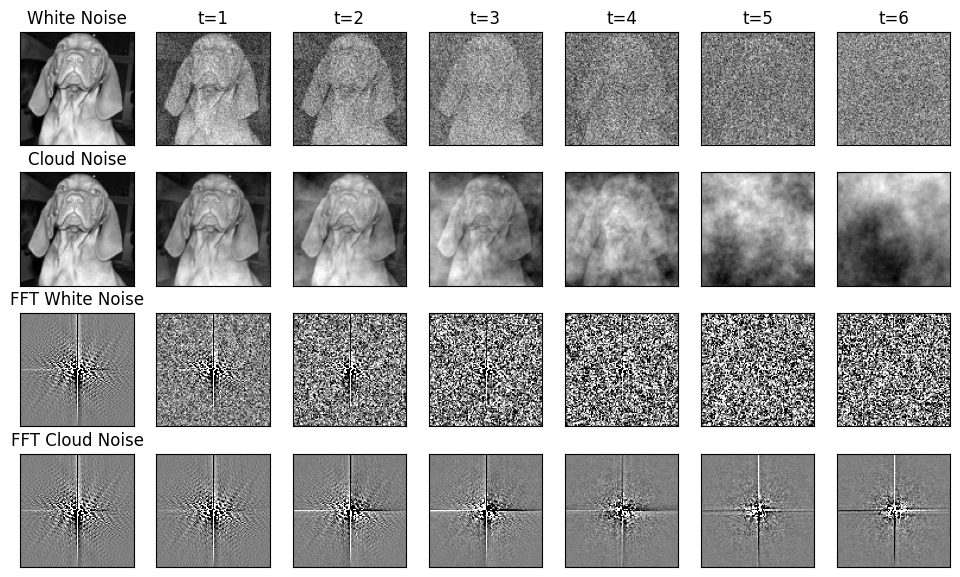

In [10]:
# Plotting the forward diffusion process for white and cloud noise in real space and Real Fourier Space. 
randint = np.random.randint(len(clean_dataset))
white_x = clean_dataset[randint][0].squeeze().to("cpu")
white_x = helpers.normalize(white_x, mu.to("cpu"), std.to("cpu"))
cloud_x = white_x.clone()
white_X = rfft(white_x)
cloud_X = rfft(cloud_x)

T=6
fig, axs = plt.subplots(nrows=4, ncols=T+1, figsize=(12, 7))

# Remove axes labels
plt.setp(axs, xticks=[], yticks=[])


for t in range(T+1):
    cloud_noise, _ = noise_generator.generate_monochrome_noise(batch_size=1,A=A, Delta=Delta)
    cloud_noise = cloud_noise.real.squeeze().to("cpu")
    white_noise = torch.randn(96,96, device="cpu")
    
    at = np.sqrt(1-t/T)
    bt = np.sqrt(t/T)
    
    white_x = at*white_x + bt*white_noise
    cloud_x = at*cloud_x + bt*cloud_noise
    
    white_X = rfft(white_x)
    cloud_X = rfft(cloud_x)

    axs[0][t].imshow(helpers.denormalize(white_x, mu.to("cpu"), std.to("cpu")), cmap="gray")
    axs[1][t].imshow(helpers.denormalize(cloud_x, mu.to("cpu"), std.to("cpu")), cmap="gray")
    axs[2][t].imshow(white_X, cmap="gray", vmin=-.7, vmax=.7)
    axs[3][t].imshow(cloud_X, cmap="gray", vmin=-.7, vmax=.7)
    
    axs[0][t].set_title(f"t={t}")

axs[0][0].set_title("White Noise")
axs[1][0].set_title("Cloud Noise")
axs[2][0].set_title("RFFT White Noise")
axs[3][0].set_title("RFFT Cloud Noise")
plt.show()

Notice that the the white noise diffusion schedule obscures fine details quickly and gradually obscures fine to coarse details until the image is entirely replaced by noise. In contrast, some of the fine details are still present in the cloud diffusion process even at late timesteps, while some coarse features are obscured early in the diffusion schedule. 

In Real Fourier Space, the image at $t=T$ looks nothing like the image at $t=0$. However, the cloud noise procedure retains some of the characteristic features of the original image. This is because the Real Fourier Transform natural image set to lowest order is a subset of $\mathcal{N}(0,\Sigma)$, just like cloud noise, while white noise is a representative sample of $\mathcal{N}(0,I_{N,N})$. 

## Reverse Diffusion Process
The reverse diffusion process for cloud diffusion works similar to ordinary diffusion. We train a network to separate out the signal from the noise. The network is evaluated and gradients are computerd from a loss function that characterizes how accurately it can model the noise at any given time step.

### The Loss Function
In the original DDPM publications, the loss function is derived starting from the Kullback-Leibler divergence. However, many assumption are made in the derivation, and it is found that the models train better when some prefactors that depend on the timestep are omitted. The end result is that the working loss function has the simple form of the L2-norm
$$
L_2(\varepsilon_{\theta}|\varepsilon_{t}) = \left|\varepsilon^{ij}_{\theta}-\varepsilon^{ij}_{t} \right|^2
$$
where $\varepsilon_{\theta}$ is the predicted noise given a set of tuneable model parameters that we collectively denote by $\theta$, and $\varepsilon_{t}$ is the actual noise at timestep $t$.

We suggest an alternative approach here that makes the translation to Cloud Diffusion more clear. We suggest that the loss function above should be thought of as the negative log likelihood loss assuming that the models predictions lie in a normal distribution with mean equal to the true noise, and variance proportional to the variance tensor of the noise. That is, we assume $\varepsilon_{\theta} \sim \mathcal{N}(\varepsilon_{t}, \Sigma)$. The density function of this normal distribution is (suppressing indices for clarity)
$$
f(\varepsilon_\theta) = \frac{\exp\left({-\frac{1}{2}\left({{\varepsilon}_\theta-\varepsilon_t}\right)\Sigma^{-1}\left(\varepsilon_\theta-\varepsilon_t\right)^T}\right)}{\sqrt{(2\pi)^{N^2} |\Sigma|}}\,.
$$
The negative log likelihood is then
$$
\text{NLLLoss}(\varepsilon_\theta|\varepsilon_t) \ \propto \ \left(\left(\varepsilon_\theta-\varepsilon_t\right)\Sigma^{-1}\left(\varepsilon_\theta-\varepsilon_t\right)^T\ +\ \text{Constants}\right)\,.
$$
For white noise, the variance tensor is ${\Sigma^{ij}}_{kl} =\delta^i_k\delta^j_l$, so the the inverse is also diagonal: ${{\Sigma^{-1}}^{ij}}_{kl} =\delta^i_k\delta^j_l$. Thus, the negative log likelihood for the white noise model is
$$
\text{NLLLoss}(\varepsilon_\theta|\varepsilon_t) \ \propto L_2(\varepsilon_{\theta}|\varepsilon_{t}) \ +\ \text{Constants}\,.
$$
Note that the gradients of $\text{NLLLoss}(\varepsilon_\theta|\varepsilon_t)$ are proportional to the gradients of $L_2(\varepsilon_{\theta}|\varepsilon_{t})$. In the above, to simplify our loss function, we've assumed that the variance of the distribution is not model dependent. Allowing the variance to be model dependent has been explored (cite), and extending that approach here may be a topic for future research.

We also note that given a probability distribution (not necessarily normal) with norm $\mu$, variance $\Sigma$, and a sample $x$, the term $d(x,\mu)=\sqrt{\left(x-\mu\right)\Sigma^{-1}\left(x-\mu\right)^T}$ is referred to as the **Mahalanobis Distance** between the test point $x$ and the norm $\mu$ in the distribution $Q$. More generally, given two points $x\sim Q$ and $y\sim Q$ the Mahalanobis Distance between them in $Q$ is:
$$
d_M(x,y) = \sqrt{\left(x-y\right)\Sigma^{-1}\left(x-y\right)^T}\,.
$$
Thus, we will refer to our loss function as the **Mahalanobis-Loss** (or Maha-Loss for short) between the model's prediction for the noise and the true noise at timestep $t$. 

Our reason for relating the loss function to the NLLLoss of a normal distribution and the Mahalanobis Distance is that gives us an avenue for constructing a reasonable loss function for the Cloud Diffusion Model. While the variance tensor for Cloud Noise is not diagonal in real space, the variance tensor is diagonal in Real Fourier Space. Working in real Fourier Space in the Cloud Diffusion Model, we might expect that the predicted noise $\widetilde{\varepsilon}^{ij}_\theta = \mathcal{F}_{\mathbb{R}}(\varepsilon^{ij}_\theta)$ is a sample from the normal distribution $\mathcal{N}(\widetilde{\varepsilon}_{t}, \Sigma)$ where $\Sigma$ is now the scale invariant variance tensor of Cloud Noise.

For scale invariant noise, in Real Fourier Space we have seen that the variance is:
$$
{\Sigma^{ij}}_{kl} = A^2\frac{\delta^i_k \delta^j_l}{|k|^{2\Delta}}\,.
$$
Being diagonal, this tensor is easy to invert:
$$
{(\Sigma^{-1})^{ij}}_{kl} = \frac{|k|^{2\Delta}}{A^2}\delta^i_k \delta^j_l\,,
$$
where it is understood that $|k|=|k^{ij}|$ is the Euclidean distance between the point $ij$ and the origin in Fourier Space. Different choices for the overall scaling factor of this distance can be absorbed into the constant $A$. In this work we've chosen a scaling such that the image has unit width and height. This gives the Maha-Loss (up to a scaling constant that we omit here):
$$
L_M(\widetilde{\varepsilon}_\theta|\widetilde{\varepsilon}_t) = (\widetilde{\varepsilon}_\theta-\widetilde{\varepsilon}_t)|k|^{2\Delta}(\widetilde{\varepsilon}_\theta-\widetilde{\varepsilon}_t)^T\,.
$$

In practice we have found that the Maha-Loss trains all frequencies better than the flat profile $L_2(\widetilde{\varepsilon}_\theta|\widetilde{\varepsilon}_t) = |\widetilde{\varepsilon}_\theta-\widetilde{\varepsilon}_t|^2$, which tends to put too much weight on low frequencies (long wavelengths) and tends to ignore high frequencies (short wavelengths). It can also sometimes happen that the Maha-Loss swings too far in the other direction and undertrains low frequencies. This tends to arise from numerical issues near the origin where the distance $|k|$ is close to zero. To skirt around these issues, it is sometimes useful to introduce a small regulator to the Euclidean distance taking $|k|^{2\Delta}\rightarrow (|k|+\epsilon)^{2\Delta}$ . We will refer to this as the **Regulated Mahalanobis-Loss**:
$$
L^{(\epsilon)}_M(\widetilde{\varepsilon}_\theta|\widetilde{\varepsilon}_t) = (\widetilde{\varepsilon}_\theta-\widetilde{\varepsilon}_t)(|k|+\epsilon)^{2\Delta}(\widetilde{\varepsilon}_\theta-\widetilde{\varepsilon}_t)^T\,.
$$

## Cloud Noise is Closer
In the preceding we alluded multiple times to the distance between the noise distribution and the distribution of the natural image set, claiming that Cloud Noise is in some sense "closer" to the natural image set than white noise. We can now quantify this statement. 

The Mahalanobis distance gives us a natural distance function that we define on a probability distribution. Given a distribution $Q$, and two samples $x\sim Q_1$ and $y\sim Q_2$ from two (possibly different) distributions, the Mahalanobis Distance between $x$ and $y$ is:
$$
d_M(x,y|Q) = \sqrt{(x-y)^T\Sigma^{-1}(x-y)}
$$
where $\Sigma$ is the variance in $Q$. Note that the distance is defined on a distribution $Q$ but the samples do not need to come from the same distribution. We can also define the the Mahalanobis Distance between a single sample $x\sim Q_1$ and a distribution $Q$ to be the Mahalanobis Distance between $x$ and the mean value of $Q$:
$$
d_M(x|Q) = \sqrt{(x-\mu)^T\Sigma^{-1}(x-\mu)}
$$

It is often more useful to consider the expectation value of the Mahalanobis Distance to get a measure of the "distance" between two distributions. Thus, we define the Mahalanobis Distance between to distriutions $Q_1$ and $Q_2$ relative to the Mahalanobis metric on $Q$ as:
$$
\begin{eqnarray}
\overline{d_M}(Q_1,Q_2|Q) &=& \mathbb{E}_{x\sim Q_1,y\sim Q_2}\left[d_M(x,y|Q) \right] \\
&=& \mathbb{E}_{x\sim Q_1,y\sim Q_2} \left[\sqrt{(x-y)^T\Sigma^{-1}(x-y)}\right]
\end{eqnarray}
$$
Similarly, we define the Mahalanobis Distance between one distribution and $Q$ as:
$$
\begin{eqnarray}
\overline{d_M}(Q_1|Q) &=& \mathbb{E}_{x\sim Q_1}\left[d_M(x|Q) \right] \\
&=& \mathbb{E}_{x\sim Q_1} \left[\sqrt{(x-\mu)^T\Sigma^{-1}(x-\mu)}\right]
\end{eqnarray}
$$
where $\mu$ is the mean of $Q$.

### Mahalanobis Distance Between White Noise, Cloud Noise, and the Image Set
Below we calculate the Mahalanobis Distances among our three sets: White Noise, Cloud Noise, and the Image Set Distribution. To calculate the Maha-Distances, we work entirely in Real Fourier Space, and we assume that the variance on the base distribution $Q$ is precisely ${\Sigma^{ij}}_{kl} = A^2\frac{\delta^i_k\delta^j_l}{|k|^{2\Delta}}$, which gives an inverse variance ${(\Sigma^{-1})^{ij}}_{kl} = \frac{|k|^{2\Delta}}{A^2}\delta^i_k\delta^j_l$.

In [30]:
distances = helpers.maha_distances(dataloader,
                                   mu=mu, 
                                   std=std, 
                                   A=A,
                                   Delta=Delta, 
                                   noise_generator=noise_generator, 
                                   device=device, 
                                   batch_size=64)

d(cloud_noise,cloud_noise|Q) = 2.747612953186035
     d(cloud_noise,images|Q) = 4.184476375579834
            d(cloud_noise|Q) = 1.9405230283737183
          d(images,images|Q) = 5.296105861663818
                 d(images|Q) = 3.6598563194274902
d(white_noise,white_noise|Q) = 27.3253231048584
d(white_noise,cloud_noise|Q) = 19.422639846801758
     d(white_noise,images|Q) = 19.699464797973633
            d(white_noise|Q) = 19.32280921936035


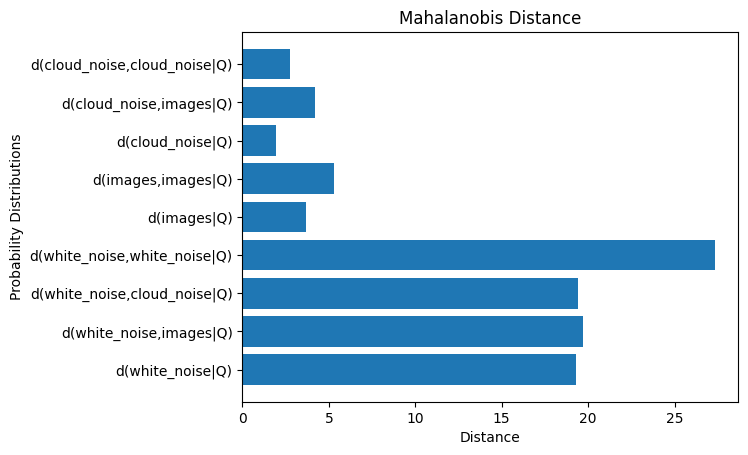

In [34]:
plt.barh(list(distances.keys())[::-1], list(distances.values())[::-1])
plt.title('Mahalanobis Distance')
plt.xlabel('Distance')
plt.ylabel('Probability Distributions')
plt.show()

Above is a plot of the Mahalanobis Distances for samples of cloud noise, white noise, and images from the dataset. As we can see from the plot, the Mahalanobis Distances between any sample set and white noise is considerably larger than all distances involving cloud noise and the image set. Thus, as expected the Mahalanobis Distance quantifies the statement:

>_Cloud noise is closer to natural image sets than white noise_

In [438]:
# filt = 2*torch.rand(3,3)-1
# x = torch.zeros(96,96)
# for i in range(3):
#     for j in range(3):
#         x[96//2-1+i, 96//2-1+j]=filt[i,j]

randint = np.random.randint(len(clean_dataset))
    
x = clean_dataset[randint][0].squeeze()

f = rfft(x)

plt.imshow(f.abs(), cmap="gray")
plt.show()
        
plt.imshow((f.angle()/(2*np.pi)+.5), cmap="twilight_shifted")
plt.show()

print((f.angle()/(2*np.pi)+.5).mean())

NameError: name 'clean_dataset' is not defined